<a href="https://colab.research.google.com/github/shitote/dist-repo/blob/main/introduction_to_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## NLP are also refered to as a sequence to sequence problems.(seq2seq)

In [1]:
!nvidia-smi -L

/bin/bash: line 1: nvidia-smi: command not found


In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# import helper functions.
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

--2024-05-03 13:09:33--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-05-03 13:09:33 (79.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Get a text dataset
Kaggle's introduction to NLP dataset (text samples of Tweets labbelled as disaster or not disarster)

In [3]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

# Unzip the data
unzip_data("nlp_getting_started.zip")

--2024-05-03 13:09:40--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.167.207, 172.253.115.207, 172.253.122.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.167.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.007s  

2024-05-03 13:09:40 (77.5 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



## Visualizing a text dataset.

Read the text file in the notebook

In [4]:
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
train_df["text"][1]

'Forest fire near La Ronge Sask. Canada'

In [6]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [7]:
# Note that the test data frame have no target values.
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [8]:
# Find Out if the dataset is baklanced or not?
train_df.target.value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

In [9]:
# Find the number of total samples.
len(train_df), len(test_df)

(7613, 3263)

In [10]:
# visualize random training examples.
import random
random_index = random.randint(0, len(train_df)-5)
for row in train_df_shuffled[["text", "target"]][random_index:random_index+10].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(Not real disaster)")
  print(f"Text:\n{text}\n")
  print("-----\n")

Target: 0 (Not real disaster)
Text:
&gt;As soon as maintenance ends everyone floods the servers
&gt;Servers destroyed by extreme load
&gt;Maintenance starts anew

-----

Target: 1 (real disaster)
Text:
Cancers equate for around 25% of all deaths in #Blackpool. 

Kowing the signs could save your life: http://t.co/5lNIdvoBff
#BeClearOnCancer

-----

Target: 0 (Not real disaster)
Text:
Kosciusko police investigating pedestrian fatality hit by a train Thursday http://t.co/m5djLLxoZP

-----

Target: 0 (Not real disaster)
Text:
I guess ill never be able to go to mayhem...

-----

Target: 1 (real disaster)
Text:
@Drothvader @CM_Nevalistis you can keep this please!!!!! Arachys
    [2 Pieces] - Now deals 4000% weapon damage (up from 2500%)

-----

Target: 0 (Not real disaster)
Text:
I had to grill for a school function. One of the grills we had going was pretty much either off or forest fire. No inbetween! Made it work

-----

Target: 1 (real disaster)
Text:
@IcyMagistrate ÛÓher upper armÛÒ t

### Split the data into training and validation sets

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled['text'].to_numpy(),
                                                                            train_df_shuffled['target'].to_numpy(),
                                                                            test_size=0.1,
                                                                            random_state=42)
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [13]:
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

## Coverting text to numbers
* Tokenization - This is direct mapping of token to number
* Emmbedding - Create a matrix of feature vectors for each token (
    the size fo the feature vector can be defined for each token embedding can be learned
)

### Text vectorization (tokenization)

In [14]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

# Use the default TextVectorization parameters.
text_vectorizer = TextVectorization(max_tokens=None,  # How many words in the vocabulary (automaticaly add <oov>)
                                    standardize='lower_and_strip_punctuation',  # Remove the fluf
                                    split='whitespace',
                                    ngrams=None,
                                    output_mode="int",
                                    output_sequence_length=None,
                                    pad_to_max_tokens=False
                                    )

In [15]:
len(train_sentences[0].split())

7

In [16]:
# Find the average number of tokens (words) in the training tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [17]:
# set text vectorization variables
max_vocab_length = 1000
max_length = 16

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode='int',
                                    output_sequence_length=max_length)

In [18]:
# Fit the text vectorizer to the trainin text
text_vectorizer.adapt(train_sentences)

In [19]:
# Create a sample sentence and tokenize it
sample_sentence = "There are floods everywhere"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 16), dtype=int64, numpy=
array([[ 74,  22, 207,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0]])>

In [20]:
random_sentence = random.choice(train_sentences)
print(f'Original text: \n {random_sentence}\n\n Vectorized version:')
text_vectorizer([random_sentence])

Original text: 
 Broadcast journalism: hostages to fortune otherwise quot-television blind else quot-operations since-3g superv...

 Vectorized version:


<tf.Tensor: shape=(1, 16), dtype=int64, numpy=
array([[  1,   1, 422,   5,   1,   1,   1,   1,   1,   1,   1,   1,   0,
          0,   0,   0]])>

In [21]:
# et the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5]
bottom_5_words = words_in_vocab[-5:]
print(f'Number of words i vocab: {len(words_in_vocab)}')
print(f'5 most common words: {top_5_words}')
print(f'5 least common words: {bottom_5_words}')

Number of words i vocab: 1000
5 most common words: ['', '[UNK]', 'the', 'a', 'in']
5 least common words: ['reported', 'r', 'pray', 'playlist', 'patience']


In [22]:
### Create an Embedding using an embedding layer
from tensorflow.keras import layers
embedding = layers.Embedding(input_dim=max_vocab_length,  # set the input shape
                            output_dim=128,  # output shape
                            input_length=max_length # how long is each input
                            )

embedding


In [23]:
# Get a random sentence from the training set
random_sentence = random.choice(train_sentences)
print(f"Original text: \n {random_sentence} \
      \n\nEmbedding version: ")

sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text: 
 May Allah help all those suffering from the #Pakistan floods! You and your families are in our #Dua       

Embedding version: 


<tf.Tensor: shape=(1, 16, 128), dtype=float32, numpy=
array([[[-0.03296299,  0.00303477,  0.02883566, ..., -0.00418099,
          0.04755262, -0.04645465],
        [-0.04703653, -0.00588825, -0.03883996, ...,  0.03672428,
          0.0125061 , -0.03197222],
        [ 0.02575675,  0.03916793,  0.02467722, ...,  0.01542549,
         -0.03370025, -0.02517889],
        ...,
        [-0.03513241,  0.01364296,  0.01966106, ...,  0.04202441,
          0.02902467, -0.03406873],
        [ 0.02736547, -0.02573804, -0.00280112, ..., -0.03664494,
          0.0056379 , -0.01784753],
        [-0.0386338 ,  0.03994048, -0.04195789, ...,  0.02895975,
         -0.0476914 , -0.00684245]]], dtype=float32)>

## Modelling a text dataset (running a serries of experiments)

The data is now in numbers it is time to build a series of modelling experiments.

* model 0: naive bayes (baseline), this is from sklearn ML
* model 1: Feed-forward neural network (dence model)
* model 2: LSTM model (RNN)
* model 3: GRU model (RNN)
* model 4: Bidirectional Neural Networks(RNN)
* model 5: !D Convolutional neural nerworks (CNN)
* model 6: Tensoflow hub Pretrained Feature extraction (using transfer learnin NLP)
* model 7: Same as model 6 with 10% of training data.

THs use od standard steps of modelling in tensorflow:
* Crreate a model.
* Build a model.
* FIt the model.
* Evaluate the model.

### Model 0: Getting a baseline.

**NOte** It is a better proctice to use non-DL alorithms to create the baseline model since they are fast and easy to train then latter impliment it with the DL to improve the performance.

In [24]:
# Trun the data into numerical.
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a tokenization and modellin pipeline.
model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()),   #Convert words to numbers.
    ("clf", MultinomialNB())
])

model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [25]:
# Baseline model evaluation.
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Baseline model score: {baseline_score*100:.2f}%")

Baseline model score: 79.27%


In [26]:
# Make predictions.
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

In [27]:
train_labels

array([0, 0, 1, ..., 1, 1, 0])

In [28]:
# Fuction to evalate: accuracy, precision, recall, f1_score.
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.
  """
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                   "precision": model_precision,
                   "recall": model_recall,
                   "f1": model_f1}
  return model_results


In [29]:
# Get baseline results
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

### Model_1: A simple dence model

In [30]:
# Create a tensorboard callback (need to create a new one for each model)
from helper_functions import create_tensorboard_callback

SAVE_DIR = 'model_logs'

In [31]:
# Build a model using the functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)  # Input are 1-dimensional array of string.
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_1 = tf.keras.Model(inputs, outputs, name='model_1_dense')

In [32]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 16)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 16, 128)           128000    
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 128129 (500.50 KB)
Trainable params: 12

In [33]:
model_1.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [34]:
train_sentences.shape, train_labels.shape

((6851,), (6851,))

In [35]:
train_labels = tf.reshape(train_labels, (-1, 1))
val_labels = tf.reshape(val_labels, (-1, 1))

In [36]:
model_1_history = model_1.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR, experiment_name='model_1_dence')])

Saving TensorBoard log files to: model_logs/model_1_dence/20240503-130943
Epoch 1/5
215/215 [==============================] - 2s 5ms/step - loss: 0.6220 - accuracy: 0.6665 - val_loss: 0.5618 - val_accuracy: 0.7388
Epoch 2/5
215/215 [==============================] - 1s 4ms/step - loss: 0.4945 - accuracy: 0.7843 - val_loss: 0.4980 - val_accuracy: 0.7664
Epoch 3/5
215/215 [==============================] - 1s 4ms/step - loss: 0.4388 - accuracy: 0.8082 - val_loss: 0.4841 - val_accuracy: 0.7822
Epoch 4/5
215/215 [==============================] - 1s 4ms/step - loss: 0.4115 - accuracy: 0.8174 - val_loss: 0.4841 - val_accuracy: 0.7835
Epoch 5/5
215/215 [==============================] - 1s 7ms/step - loss: 0.3944 - accuracy: 0.8246 - val_loss: 0.4826 - val_accuracy: 0.7822


In [37]:
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 4ms/step - loss: 0.4826 - accuracy: 0.7822


[0.48256632685661316, 0.7821522355079651]

In [38]:
# Make somce Predictions and evaluate them
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs.shape

24/24 [==============================] - 0s 3ms/step


(762, 1)

In [39]:
model_1_pred_probs[0]

array([0.54228], dtype=float32)

In [40]:
# Convert the models prediction into probabilities to label format
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32)>

In [41]:
model_1_results = calculate_results(y_true=val_labels,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.21522309711287,
 'precision': 0.7856661242905698,
 'recall': 0.7821522309711286,
 'f1': 0.7795215466562155}

In [42]:
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

## Visualize the learned embedding.

In [43]:
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(1000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [44]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 16)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 16, 128)           128000    
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 128129 (500.50 KB)
Trainable params: 12

In [45]:
# Get the wight metrix of embeddin layer
embed_weights = model_1.get_layer("embedding").get_weights()[0]
embed_weights.shape

(1000, 128)

### Create embedding files.

In [46]:
import io
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + '\n')
  out_m.write(word + '\n')
out_v.close()
out_m.close()

In [47]:
# Dowload file from colab to upload to the projector
# word to vector jay alama
try:
  from google.colab import files
  files.download("vectors.tsv")
  files.download('metadata.tsv')
except Exception:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Recurrent Neural Networks (RNN)

RNN are useful for sequence data.

The premise of a recurrent neuaral network is to use the representatoin of a previous input to aid the representation of a later input

The internals of RNN:
- MIT's sequence modelling.
- Chris olah's intor to LSTMs:
- Andrej Kapathy's the unreasonable effectiveness of recurrent neural networks.

### Model 2: LSTM
LSTM = Long short term memory (One of the most popular LSTM cells)
* The structure of an RNN trypically looks like this:

```
Input (text) -> Tokenize -> Embedding -> Layers (RNNs/dense) -> Output (label probabilities)

In [48]:
# Tenh
# Create an LSTM model.
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.LSTM(64, return_sequences=True)(x)
x = layers.LSTM(64)(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_2 = tf.keras.Model(inputs, outputs, name='model_2_LSTM')

In [49]:
# Compile the model.
model_2.compile(loss='binary_crossentropy',
  optimizer=tf.keras.optimizers.Adam(),
  metrics=["accuracy"])

In [50]:
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 'model_2_LSTM')])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20240503-130951
Epoch 1/5
215/215 [==============================] - 22s 57ms/step - loss: 0.4054 - accuracy: 0.8256 - val_loss: 0.5037 - val_accuracy: 0.7808
Epoch 2/5
215/215 [==============================] - 10s 47ms/step - loss: 0.3815 - accuracy: 0.8318 - val_loss: 0.4786 - val_accuracy: 0.7743
Epoch 3/5
215/215 [==============================] - 7s 32ms/step - loss: 0.3731 - accuracy: 0.8359 - val_loss: 0.4791 - val_accuracy: 0.7835
Epoch 4/5
215/215 [==============================] - 5s 25ms/step - loss: 0.3605 - accuracy: 0.8456 - val_loss: 0.5029 - val_accuracy: 0.7743
Epoch 5/5
215/215 [==============================] - 5s 21ms/step - loss: 0.3401 - accuracy: 0.8542 - val_loss: 0.4921 - val_accuracy: 0.7756


In [51]:
# Make predictions with the LSTM model.
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

24/24 [==============================] - 1s 6ms/step


array([[0.7462047 ],
       [0.66526484],
       [0.9100309 ],
       [0.10734388],
       [0.09480448],
       [0.98980784],
       [0.9463418 ],
       [0.8068199 ],
       [0.575445  ],
       [0.17574479]], dtype=float32)

In [52]:
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [53]:
# Calculate model 2 results
model_2_results = calculate_results(y_true = val_labels,
                                    y_pred = model_2_preds)
model_2_results

{'accuracy': 77.55905511811024,
 'precision': 0.7783607884132258,
 'recall': 0.7755905511811023,
 'f1': 0.7730920642120304}

### Model 3: GRU

This is also a popular RNN component GRU - gated recurrent Unit

The GRU have the same features to an LSTM cell but have less parameters,

RFewources:
understantin the GRU networks by simion


In [54]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64, return_sequences=True)(x)
# x = layers.LSTM(64)(x)
x = layers.GRU(64)(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_3 = tf.keras.Model(inputs, outputs, name='model_3_GRU')

In [55]:
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 16)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 16, 128)           128000    
                                                                 
 gru (GRU)                   (None, 16, 64)            37248     
                                                                 
 gru_1 (GRU)                 (None, 64)                24960     
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                       

In [56]:
# Compile the model
model_3.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [57]:
# Fit the model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'model_3_GRU')])

Saving TensorBoard log files to: model_logs/model_3_GRU/20240503-131042
Epoch 1/5
215/215 [==============================] - 10s 24ms/step - loss: 0.3948 - accuracy: 0.8282 - val_loss: 0.4954 - val_accuracy: 0.7756
Epoch 2/5
215/215 [==============================] - 5s 21ms/step - loss: 0.3388 - accuracy: 0.8606 - val_loss: 0.6015 - val_accuracy: 0.7769
Epoch 3/5
215/215 [==============================] - 5s 23ms/step - loss: 0.3183 - accuracy: 0.8688 - val_loss: 0.5147 - val_accuracy: 0.7808
Epoch 4/5
215/215 [==============================] - 4s 19ms/step - loss: 0.2934 - accuracy: 0.8780 - val_loss: 0.5853 - val_accuracy: 0.7677
Epoch 5/5
215/215 [==============================] - 5s 24ms/step - loss: 0.2723 - accuracy: 0.8810 - val_loss: 0.6929 - val_accuracy: 0.7362


In [58]:
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs[:10]

24/24 [==============================] - 1s 5ms/step


array([[0.9763075 ],
       [0.7405918 ],
       [0.9582172 ],
       [0.02797285],
       [0.08855324],
       [0.99898946],
       [0.99878937],
       [0.9200504 ],
       [0.47366017],
       [0.0847753 ]], dtype=float32)

In [59]:
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 0., 0., 1., 1., 1., 0., 0.], dtype=float32)>

In [60]:
model_3_results = calculate_results(y_true=val_labels,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 73.62204724409449,
 'precision': 0.7361116379305274,
 'recall': 0.7362204724409449,
 'f1': 0.7345858470183851}

### Model 4: Bidirectional RNN

Normal RNN's go from left to right (the same way you will read a kiswahili sentence).
The bidirection RNN go from right to let as well as from  left to right

In [61]:
# Build a bidirection RNN
inputs = layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.GRU(64))(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name='model_4_bidirectional')

In [62]:
model_4.summary()

Model: "model_4_bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 16)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 16, 128)           128000    
                                                                 
 bidirectional (Bidirection  (None, 16, 128)           98816     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               74496     
 onal)                                                           
                                             

In [63]:
model_4.compile(loss="binary_crossentropy",
                optimizer= tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [64]:
# Fit the model
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'model_4_bidirectional')])

Saving TensorBoard log files to: model_logs/model_4_bidirectional/20240503-131129
Epoch 1/5
215/215 [==============================] - 17s 46ms/step - loss: 0.3464 - accuracy: 0.8567 - val_loss: 0.5191 - val_accuracy: 0.7585
Epoch 2/5
215/215 [==============================] - 8s 35ms/step - loss: 0.2824 - accuracy: 0.8784 - val_loss: 0.6087 - val_accuracy: 0.7520
Epoch 3/5
215/215 [==============================] - 10s 45ms/step - loss: 0.2644 - accuracy: 0.8840 - val_loss: 0.6593 - val_accuracy: 0.7415
Epoch 4/5
215/215 [==============================] - 10s 45ms/step - loss: 0.2447 - accuracy: 0.8958 - val_loss: 0.7021 - val_accuracy: 0.7677
Epoch 5/5
215/215 [==============================] - 8s 37ms/step - loss: 0.2233 - accuracy: 0.9044 - val_loss: 0.7884 - val_accuracy: 0.7480


In [65]:
# make predictions.
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

24/24 [==============================] - 2s 10ms/step


array([[0.98248607],
       [0.6987816 ],
       [0.98926896],
       [0.03139645],
       [0.1190946 ],
       [0.9999693 ],
       [0.999881  ],
       [0.9559126 ],
       [0.5713061 ],
       [0.15409574]], dtype=float32)

In [66]:
# Turn the results into a comparable features.
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [67]:
model_4_results = calculate_results(val_labels, model_4_preds)
model_4_results

{'accuracy': 74.80314960629921,
 'precision': 0.7479456805993138,
 'recall': 0.7480314960629921,
 'f1': 0.7466477519674009}

## Convolutional Neural Networks for text and othet types od seu=quences

The typical structure of a convolutional neural network

Input (text) -> Tokenization -> Embedding -> Layers (typically conv1D + pooling) -> Outputs (class probabilities)

### Model 5: conv1D

In [68]:
# Make a test of the embedding layer, conv1D layer and max pooling layers
from tensorflow.keras import layers
embedding_test = embedding(text_vectorizer(["this is a test sentence"]))
conv_1d = layers.Conv1D(filters=32,
                        kernel_size=5,
                        activation='relu',
                        padding='valid')
conv_1d_output = conv_1d(embedding_test)  # pass the test embeddin into the conv1d layer.
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output)   # get the most important fearutes.

embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 16, 128]), TensorShape([1, 12, 32]), TensorShape([1, 32]))

In [69]:
embedding_test

<tf.Tensor: shape=(1, 16, 128), dtype=float32, numpy=
array([[[-0.05285578, -0.03856588,  0.00061354, ...,  0.05476036,
          0.0014188 ,  0.03318207],
        [ 0.0127703 , -0.01044403, -0.0073212 , ..., -0.05765186,
          0.01840104, -0.06599909],
        [-0.00655151,  0.02673397,  0.01784936, ..., -0.01555192,
         -0.04508962, -0.00829156],
        ...,
        [ 0.00257851, -0.02011156, -0.02035762, ..., -0.03383173,
          0.03076798, -0.01295011],
        [ 0.00257851, -0.02011156, -0.02035762, ..., -0.03383173,
          0.03076798, -0.01295011],
        [ 0.00257851, -0.02011156, -0.02035762, ..., -0.03383173,
          0.03076798, -0.01295011]]], dtype=float32)>

In [70]:
conv_1d_output[:2]

<tf.Tensor: shape=(1, 12, 32), dtype=float32, numpy=
array([[[0.        , 0.03125905, 0.01774645, 0.00726713, 0.01584675,
         0.        , 0.        , 0.01981526, 0.02854772, 0.        ,
         0.01553725, 0.        , 0.01654899, 0.        , 0.05893502,
         0.00162443, 0.        , 0.        , 0.04080294, 0.        ,
         0.01739059, 0.        , 0.03000982, 0.        , 0.02960928,
         0.00657881, 0.01649221, 0.        , 0.        , 0.        ,
         0.        , 0.0259875 ],
        [0.03657935, 0.03175825, 0.        , 0.00375543, 0.00618296,
         0.04195721, 0.        , 0.01532478, 0.        , 0.00457611,
         0.00746894, 0.        , 0.        , 0.        , 0.01096958,
         0.        , 0.        , 0.        , 0.03443798, 0.        ,
         0.00282144, 0.        , 0.        , 0.        , 0.        ,
         0.02958432, 0.00375911, 0.02240532, 0.01880036, 0.01728407,
         0.00523314, 0.01408318],
        [0.00823927, 0.        , 0.07308536, 0.    

In [71]:
max_pool_output

<tf.Tensor: shape=(1, 32), dtype=float32, numpy=
array([[0.03657935, 0.03175825, 0.08519757, 0.00726713, 0.03889767,
        0.04195721, 0.07378846, 0.0389406 , 0.02854772, 0.02149164,
        0.01553725, 0.        , 0.01654899, 0.        , 0.05893502,
        0.00162443, 0.03322285, 0.05214164, 0.06968711, 0.05646874,
        0.04624296, 0.01117047, 0.03000982, 0.04353128, 0.02960928,
        0.02958432, 0.01649221, 0.03167386, 0.01880036, 0.01728407,
        0.00523314, 0.0259875 ]], dtype=float32)>

In [72]:
# Create d dimensional convolutional neural network layer to model sequences.
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=64, kernel_size=5, strides=1, activation='relu', padding= 'valid')(x)
x = layers.GlobalMaxPool1D()(x)
# x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_5 = tf.keras.Model(inputs, outputs, name='model_5_conv1D')

# Compile the model and fit it ata one go
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

model_5.summary()

Model: "model_5_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 16)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 16, 128)           128000    
                                                                 
 conv1d_1 (Conv1D)           (None, 12, 64)            41024     
                                                                 
 global_max_pooling1d_1 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_6 (Dense)             (None, 1)              

In [73]:
train_sentences_tensor = tf.convert_to_tensor(train_sentences)
val_sentences_tensor = tf.convert_to_tensor(val_sentences)

In [74]:
# fit model 5
model_5_history = model_5.fit(train_sentences_tensor,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences_tensor, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'conv1D')])


Saving TensorBoard log files to: model_logs/conv1D/20240503-131300
Epoch 1/5
215/215 [==============================] - 2s 7ms/step - loss: 0.3675 - accuracy: 0.8386 - val_loss: 0.5369 - val_accuracy: 0.7756
Epoch 2/5
215/215 [==============================] - 1s 6ms/step - loss: 0.3319 - accuracy: 0.8589 - val_loss: 0.5580 - val_accuracy: 0.7585
Epoch 3/5
215/215 [==============================] - 1s 6ms/step - loss: 0.3046 - accuracy: 0.8749 - val_loss: 0.5791 - val_accuracy: 0.7664
Epoch 4/5
215/215 [==============================] - 1s 6ms/step - loss: 0.2773 - accuracy: 0.8857 - val_loss: 0.5833 - val_accuracy: 0.7703
Epoch 5/5
215/215 [==============================] - 1s 6ms/step - loss: 0.2441 - accuracy: 0.9038 - val_loss: 0.6162 - val_accuracy: 0.7520


In [75]:
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:5]

24/24 [==============================] - 0s 2ms/step


array([[0.8877309 ],
       [0.5125083 ],
       [0.908597  ],
       [0.06060944],
       [0.09154053]], dtype=float32)

In [76]:
# Make the results comparerable.
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))

model_5_results = calculate_results(y_true=val_labels,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 75.19685039370079,
 'precision': 0.7555317501896176,
 'recall': 0.7519685039370079,
 'f1': 0.7483944946347455}

 ## # Model 6: Tensorflow Hub Pretrained Sentence Encoder

In [77]:
# import tensorflow_hub as hub
# import tensorflow as tf

# english_sentences = tf.constant(["dog", "Puppies are nice.", "I enjoy taking long walks along the beach with my dog."])

# preprocessor = hub.KerasLayer(
#     "https://kaggle.com/models/tensorflow/bert/TensorFlow2/en-uncased-preprocess/3")
# encoder = hub.KerasLayer(
#     "https://www.kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/cmlm-en-base/1")

# english_embeds = encoder(preprocessor(english_sentences))["default"]

# print (english_embeds)


In [78]:
# !pip install tensorflow-text

In [79]:
# !pip install --upgrade tensorflow

In [80]:
import tensorflow as tf

print(tf.__version__)

2.15.0


from json import encoder
## Model 6: Tensorflow hub pretrained sentence encoder
Transfer learning for NLP, Specificaly use tensorflow hub universal sentence encoder

In [81]:
import tensorflow_hub as hub

In [82]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(module_url)
print ("module %s loaded" % module_url)
embed = model
embed_samples = embed([sample_sentence,
                       "When you add the universal sentences encoder to a sentence, it converts it to numbers"])
print(embed_samples[0][:50])


module https://tfhub.dev/google/universal-sentence-encoder/4 loaded
tf.Tensor(
[-0.05953072  0.009958    0.05262217  0.03299494  0.03481619  0.03550496
  0.03030668  0.05389166 -0.04455226  0.01692487  0.0261747  -0.00416461
  0.02361121  0.06394361  0.05907685 -0.03532546  0.03982759 -0.02722584
 -0.01726626 -0.0558493  -0.02147491  0.07448269  0.00204131  0.0272521
 -0.00876293 -0.05909175  0.01170975 -0.00945128  0.01568378  0.05079331
 -0.01973779 -0.02515237 -0.02078041 -0.01900205  0.00385312 -0.02912632
  0.03036552  0.06737051  0.00844657 -0.05294723 -0.06610619  0.00431143
 -0.0285227   0.05258462 -0.09454233  0.00011859 -0.0305081   0.00793438
 -0.05065931  0.03487634], shape=(50,), dtype=float32)


In [83]:
embed_samples

<tf.Tensor: shape=(2, 512), dtype=float32, numpy=
array([[-0.05953072,  0.009958  ,  0.05262217, ...,  0.01666443,
         0.00035226, -0.03008756],
       [ 0.05224953, -0.0920862 , -0.01916212, ..., -0.04403271,
         0.03968364,  0.00878738]], dtype=float32)>

In [84]:
# Create a keras layer using pretrained layer from Hub
sentence_encoder_layer = hub.KerasLayer(
    "https://tfhub.dev/google/universal-sentence-encoder/4",
    input_shape=[],
    dtype=tf.string,
    trainable=False,
    name="USE"
    )

In [85]:
# Create the model using sequential API
model_6 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
], name='model_6_USE')

In [86]:
# Compile the model
model_6.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])
model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_7 (Dense)             (None, 64)                32832     
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [87]:
# TRain a classifier on top of USE embeddings
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'tf_hub_sentence_encoder')])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20240503-131339
Epoch 1/5
215/215 [==============================] - 5s 11ms/step - loss: 0.5050 - accuracy: 0.7808 - val_loss: 0.4510 - val_accuracy: 0.7953
Epoch 2/5
215/215 [==============================] - 2s 9ms/step - loss: 0.4138 - accuracy: 0.8181 - val_loss: 0.4359 - val_accuracy: 0.8123
Epoch 3/5
215/215 [==============================] - 3s 14ms/step - loss: 0.4002 - accuracy: 0.8241 - val_loss: 0.4312 - val_accuracy: 0.8163
Epoch 4/5
215/215 [==============================] - 2s 10ms/step - loss: 0.3915 - accuracy: 0.8256 - val_loss: 0.4287 - val_accuracy: 0.8163
Epoch 5/5
215/215 [==============================] - 2s 10ms/step - loss: 0.3843 - accuracy: 0.8310 - val_loss: 0.4260 - val_accuracy: 0.8150


In [88]:
# make predictions with USE TF HUb model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

24/24 [==============================] - 1s 8ms/step


array([[0.18530607],
       [0.78646183],
       [0.99169254],
       [0.19617733],
       [0.742662  ],
       [0.71916604],
       [0.9833743 ],
       [0.982596  ],
       [0.9474183 ],
       [0.10156891]], dtype=float32)

In [89]:
# Convert prediction probabilities to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [90]:
# Calculate the model 6 performance metrics
model_6_results = calculate_results(y_true=val_labels,
                                    y_pred=model_6_preds)
model_6_results

{'accuracy': 81.49606299212599,
 'precision': 0.8175707797736699,
 'recall': 0.8149606299212598,
 'f1': 0.8133343159175271}

In [91]:
# improve the preformance of the  model
model_7 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64, activation="relu"),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
], name='model_7_USE')

In [92]:
# Compile the model.
model_7.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

model_7.summary()

Model: "model_7_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_9 (Dense)             (None, 64)                32832     
                                                                 
 dense_10 (Dense)            (None, 64)                4160      
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 256834881 (979.75 MB)
Trainable params: 37057 (144.75 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [93]:
# Fit the model.
model_7_history = model_7.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'model_7_USE')])

Saving TensorBoard log files to: model_logs/model_7_USE/20240503-131403
Epoch 1/5
215/215 [==============================] - 4s 12ms/step - loss: 0.4873 - accuracy: 0.7813 - val_loss: 0.4425 - val_accuracy: 0.8084
Epoch 2/5
215/215 [==============================] - 2s 9ms/step - loss: 0.4025 - accuracy: 0.8210 - val_loss: 0.4259 - val_accuracy: 0.8163
Epoch 3/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3821 - accuracy: 0.8352 - val_loss: 0.4245 - val_accuracy: 0.8150
Epoch 4/5
215/215 [==============================] - 3s 13ms/step - loss: 0.3647 - accuracy: 0.8445 - val_loss: 0.4193 - val_accuracy: 0.8215
Epoch 5/5
215/215 [==============================] - 2s 10ms/step - loss: 0.3449 - accuracy: 0.8546 - val_loss: 0.4210 - val_accuracy: 0.8189


In [94]:
# Make predictions for the model.
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:5]

24/24 [==============================] - 1s 8ms/step


array([[0.12310802],
       [0.79742646],
       [0.99718344],
       [0.22464344],
       [0.5453333 ]], dtype=float32)

In [95]:
# make the prediction result comparerable.
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 1., 1., 0., 1.], dtype=float32)>

In [96]:
# calculate model 7 presormance metrics.
model_7_results = calculate_results(y_true=val_labels,
                                    y_pred=model_7_preds)
model_7_results

{'accuracy': 81.88976377952756,
 'precision': 0.8242025890831443,
 'recall': 0.8188976377952756,
 'f1': 0.816593441928932}

## Model 7: TF HUB Pretrained USE with only 10% of the training data

In [97]:
# create subsets of 10% of training data
train_10_percent = train_df_shuffled[['text', 'target']].sample(frac=0.1, random_state=42)
train_10_percent.head(), len(train_10_percent), len(train_df_shuffled)

(                                                   text  target
 4955  DFR EP016 Monthly Meltdown - On Dnbheaven 2015...       0
 584   FedEx no longer to transport bioterror germs i...       0
 7411  Gunmen kill four in El Salvador bus attack: Su...       1
 5950  @camilacabello97 Internally and externally scr...       1
 5541  Radiation emergency #preparedness starts with ...       1,
 761,
 7613)

In [98]:
# This is an element of data leakages.
train_sentences_10_percent = train_10_percent['text'].to_list()
train_labels_10_percent = train_10_percent['target'].to_list()
len(train_sentences_10_percent), len(train_labels_10_percent)

(761, 761)

In [99]:
# Solve the proble of data leakage.
train_10_percent_split = int(0.1 * len(train_sentences))
train_sentences_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]
len(train_sentences_10_percent), len(train_labels_10_percent)

(685, 685)

In [100]:
train_10_percent[:10]

,text,target
4955,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0
584,FedEx no longer to transport bioterror germs i...,0
7411,Gunmen kill four in El Salvador bus attack: Su...,1
5950,@camilacabello97 Internally and externally scr...,1
5541,Radiation emergency #preparedness starts with ...,1
6358,Investigators rule catastrophic structural fai...,1
59,How the West was burned: Thousands of wildfire...,1
7018,Map: Typhoon Soudelor's predicted path as it a...,1
455,Ûª93 blasts accused Yeda Yakub dies in Karach...,1
727,My ears are bleeding https://t.co/k5KnNwugwT,0


In [101]:
pd.Series(np.array(train_labels_10_percent).ravel()).value_counts()

0    406
1    279
Name: count, dtype: int64

In [102]:
train_sentences_10_percent[:5]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk'],
      dtype=object)

#### Clone model 6 to adapt it to model 7.

In [103]:
model_7 = tf.keras.models.clone_model(model_6)

# compile the model.
model_7.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])
model_7.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_7 (Dense)             (None, 64)                32832     
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [104]:
# Fit the model to the data
model_7_history = model_7.fit(train_sentences_10_percent,
                              train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                    'tf_hub_sentence_encoder_10_percent_correct')])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder_10_percent_correct/20240503-131423
Epoch 1/5
22/22 [==============================] - 5s 46ms/step - loss: 0.6671 - accuracy: 0.6526 - val_loss: 0.6486 - val_accuracy: 0.6903
Epoch 2/5
22/22 [==============================] - 1s 24ms/step - loss: 0.5966 - accuracy: 0.8000 - val_loss: 0.5944 - val_accuracy: 0.7493
Epoch 3/5
22/22 [==============================] - 1s 24ms/step - loss: 0.5258 - accuracy: 0.8175 - val_loss: 0.5422 - val_accuracy: 0.7769
Epoch 4/5
22/22 [==============================] - 1s 24ms/step - loss: 0.4659 - accuracy: 0.8336 - val_loss: 0.5073 - val_accuracy: 0.7703
Epoch 5/5
22/22 [==============================] - 1s 24ms/step - loss: 0.4237 - accuracy: 0.8321 - val_loss: 0.4927 - val_accuracy: 0.7756


In [105]:
# Make prediction of the models that is trained on 10 percent of the data.
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:5]

24/24 [==============================] - 1s 8ms/step


array([[0.20223948],
       [0.6035208 ],
       [0.9053705 ],
       [0.37799627],
       [0.5582632 ]], dtype=float32)

In [106]:
# Turn the pred probs into labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [107]:
# Model 7 predictions evaluations.
model_7_results = calculate_results(y_true=val_labels,
                                    y_pred=model_7_preds)
model_7_results

{'accuracy': 77.55905511811024,
 'precision': 0.7761484506083779,
 'recall': 0.7755905511811023,
 'f1': 0.7741998997022081}

## Compare the performance of all the models

In [108]:
# combine model results into a dataframe
all_model_results = pd.DataFrame({"0_baseline": baseline_results,
                                  "1_simple_dense": model_1_results,
                                  "2_lstm": model_2_results,
                                  "3_gru": model_3_results,
                                  "4_bidirectional": model_4_results,
                                  "5_conv1d": model_5_results,
                                  "6_tf_hub_USE": model_6_results,
                                  "7_tf_hub_USE_10%": model_7_results
                                  })
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
0_baseline,79.265092,0.811139,0.792651,0.786219
1_simple_dense,78.215223,0.785666,0.782152,0.779522
2_lstm,77.559055,0.778361,0.775591,0.773092
3_gru,73.622047,0.736112,0.736220,0.734586
4_bidirectional,74.803150,0.747946,0.748031,0.746648
5_conv1d,75.196850,0.755532,0.751969,0.748394
6_tf_hub_USE,81.496063,0.817571,0.814961,0.813334
7_tf_hub_USE_10%,77.559055,0.776148,0.775591,0.774200


In [109]:
# Reduce the accuracy to the same scale as other metrics
all_model_results['accuracy'] = all_model_results['accuracy']/100
all_model_results

,accuracy,precision,recall,f1
0_baseline,0.792651,0.811139,0.792651,0.786219
1_simple_dense,0.782152,0.785666,0.782152,0.779522
2_lstm,0.775591,0.778361,0.775591,0.773092
3_gru,0.736220,0.736112,0.736220,0.734586
4_bidirectional,0.748031,0.747946,0.748031,0.746648
5_conv1d,0.751969,0.755532,0.751969,0.748394
6_tf_hub_USE,0.814961,0.817571,0.814961,0.813334
7_tf_hub_USE_10%,0.775591,0.776148,0.775591,0.774200


In [110]:
# prompt: Using dataframe all_model_results: scatter

import altair as alt
alt.Chart(all_model_results).mark_circle().encode(
    x='accuracy',
    y='precision',
    color=alt.Color('f1', scale=alt.Scale(scheme='viridis'))
).interactive()


alt.Chart(...)

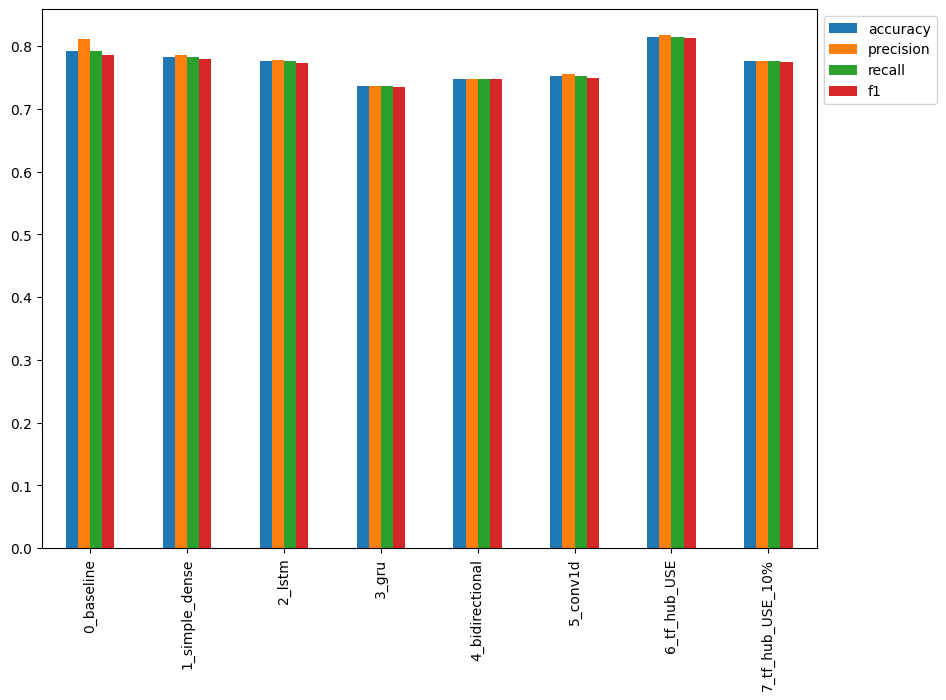

In [111]:
# Ploa and compare all of the model results
all_model_results.plot(kind='bar', figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0))

<Axes: >

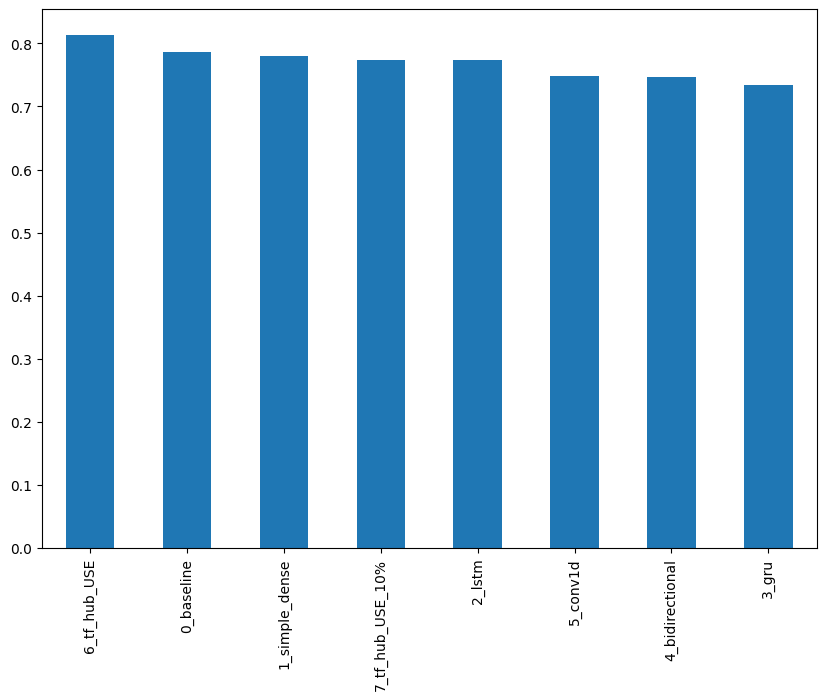

In [112]:
# Sort model results by f1_score.
all_model_results.sort_values("f1", ascending=False)['f1'].plot(kind='bar', figsize=(10, 7))

📖**Resource:** checkout weihts and bieses for experiment tracking

### Save and load the model

There are two main formats to save the model to in TensorFlow:
1. The HDF4 format,
2. The `SavedModel` format

In [113]:
model_6_results

{'accuracy': 81.49606299212599,
 'precision': 0.8175707797736699,
 'recall': 0.8149606299212598,
 'f1': 0.8133343159175271}

In [114]:
# save TF hub SE model to HDF5
model_6.save('model_6.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [115]:
# Load model with custom hub layer (reauored by HDF5)
import tensorflow_hub as hub
loaded_model_6 = tf.keras.models.load_model('model_6.h5',
                                            custom_objects={'KerasLayer': hub.KerasLayer})

In [116]:
# Evaluat the loaded model.
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 8ms/step - loss: 0.4260 - accuracy: 0.8150


[0.42595598101615906, 0.8149606585502625]

In [117]:
# use the saved model format
model_6.save("model_6_savedModel_format")

In [118]:
load_model_6_savedModel = tf.keras.models.load_model('model_6_savedModel_format')

In [119]:
# Make the evaliations of the save model.
load_model_6_savedModel.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 9ms/step - loss: 0.4260 - accuracy: 0.8150


[0.42595598101615906, 0.8149606585502625]

## Find the most wrong examples

* If the model still isn't perfect, what examples is it getting wrong?
* And of those wrong examples which one is it getting *most* wron (Those with the prediction probabilities closser to the opposite class)

**This is call data driven data exploration or active learning**

In [120]:
!wget https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
!unzip 08_model_6_USE_feature_extractor.zip

--2024-05-03 13:15:20--  https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.167.207, 172.253.115.207, 172.253.122.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.167.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 960779165 (916M) [application/zip]
Saving to: ‘08_model_6_USE_feature_extractor.zip’

08_model_6_USE_feat 100%[===================>] 916.27M  71.7MB/s    in 13s     

2024-05-03 13:15:34 (68.3 MB/s) - ‘08_model_6_USE_feature_extractor.zip’ saved [960779165/960779165]

Archive:  08_model_6_USE_feature_extractor.zip
   creating: 08_model_6_USE_feature_extractor/
   creating: 08_model_6_USE_feature_extractor/assets/
   creating: 08_model_6_USE_feature_extractor/variables/
  inflating: 08_model_6_USE_feature_extractor/variables/variables.data-00000-of-00001  
  inflating: 08_model_6_USE_feature_extractor/variables/variabl

In [121]:
model_6_pretrained = tf.keras.models.load_model('08_model_6_USE_feature_extractor')
model_6_pretrained.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 15ms/step - loss: 0.4272 - accuracy: 0.8163


[0.42723119258880615, 0.8162729740142822]

In [139]:
# Make Predictions with the loaded model
model_6_pretrained_pred_probs = model_6_pretrained.predict(val_sentences)
model_6_pretrained_preds = tf.squeeze(tf.round(model_6_pretrained_pred_probs))
model_6_pretrained_preds[:10]

24/24 [==============================] - 0s 9ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [140]:
model_6_pretrained_pred_probs = tf.squeeze(model_6_pretrained_pred_probs)
model_6_pretrained_pred_probs.shape

TensorShape([762])

TensorShape([762])

In [141]:
# Create the DataFrame
val_df = pd.DataFrame({"text": val_sentences,
                       "target": tf.squeeze(tf.round(val_labels)),
                       "pred": model_6_pretrained_preds,
                       "pred_prob": model_6_pretrained_pred_probs})
val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.159757
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.747162
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.988749
3,@camilacabello97 Internally and externally scr...,1,0.0,0.196229
4,Radiation emergency #preparedness starts with ...,1,1.0,0.707808


In [142]:
# Find the wrong prodictions and sort by prediction probabilities.
most_wrong = val_df[val_df['target'] != val_df['pred']].sort_values('pred_prob', ascending=False)
most_wrong[:10]

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.910196
759,FedEx will no longer transport bioterror patho...,0,1.0,0.876982
628,@noah_anyname That's where the concentration c...,0,1.0,0.852300
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.835454
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.827213
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.814816
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.810840
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.803122
119,@freefromwolves GodsLove &amp; #thankU brother...,0,1.0,0.766901
344,Air Group is here to the rescue! We have 24/7 ...,0,1.0,0.766625


In [144]:
# Check the false positives
for row in most_wrong[:10].itertuples():
  _, text, target, pred, pred_prob = row
  print(f"Target: {target}, Pred: {pred} Prob: {pred_prob}")
  print(f"Text:\n{text}\n")
  print("-------------------\n")

Target: 0, Pred: 1.0 Prob: 0.9101957082748413
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

-------------------

Target: 0, Pred: 1.0 Prob: 0.8769820332527161
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

-------------------

Target: 0, Pred: 1.0 Prob: 0.8523001670837402
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

-------------------

Target: 0, Pred: 1.0 Prob: 0.8354544043540955
Text:
Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0

-------------------

Target: 0, Pred: 1.0 Prob: 0.8272131681442261
Text:
@AshGhebranious civil rights continued in the 60s. And what about trans-generational trauma? if anything we should listen to the Americans.

-------------------

Target: 0, Pred: 1.0 Prob: 0.814815878868103
Text:
@SonofLiberty357 all ill

In [148]:
# Check the false neatives
for row in most_wrong[-10:].itertuples():
  _, text, target, pred, pred_prob = row
  print(f"Target: {target}, Pred: {pred}, Prob: {pred_prob}")
  print(f"Text: \n {text}")
  print("-------------\n")

Target: 1, Pred: 0.0, Prob: 0.06730345636606216
Text: 
 @DavidVonderhaar At least you were sincere ??
-------------

Target: 1, Pred: 0.0, Prob: 0.055075839161872864
Text: 
 @willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu
-------------

Target: 1, Pred: 0.0, Prob: 0.054603397846221924
Text: 
 Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets
-------------

Target: 1, Pred: 0.0, Prob: 0.05459701269865036
Text: 
 going to redo my nails and watch behind the scenes of desolation of smaug ayyy
-------------

Target: 1, Pred: 0.0, Prob: 0.04963730648159981
Text: 
 You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.
-------------

Target: 1, Pred: 0.0, Prob: 0.04391849413514137
Text: 
 @SoonerMagic_ I mean I'm a fan but I don't need a girl sounding off lik

In [150]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


 ## Makin prediction on the test dataset.

In [155]:
 test_sentences = test_df['text'].to_list()
 test_sentences[:6]

['Just happened a terrible car crash',
 'Heard about #earthquake is different cities, stay safe everyone.',
 'there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all',
 'Apocalypse lighting. #Spokane #wildfires',
 'Typhoon Soudelor kills 28 in China and Taiwan',
 "We're shaking...It's an earthquake"]

In [158]:
# Making predictions on the test dataset and visualizing them.
test_sentences = test_df['text'].to_list()
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6_pretrained.predict([test_sample]))  # the model expets a list.
  pred = tf.round(pred_prob)
  print(f"Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text: \n {test_sample}")
  print("---------\n")

1/1 [==============================] - 0s 36ms/step
Pred: 1, Prob: 0.879824161529541
Text: 
 Watch This Airport Get Swallowed Up By A Sandstorm In Under A Minute http://t.co/1ZdRKTgogD
---------

1/1 [==============================] - 0s 36ms/step
Pred: 0, Prob: 0.16919003427028656
Text: 
 Obama 'lambasted 4 not being respected &amp; 4 being a jokeÛ
Would #Trump prefer more civilian casualties?
http://t.co/gxQMDMzA1u
#GOP
#maddow
---------

1/1 [==============================] - 0s 36ms/step
Pred: 1, Prob: 0.6125904321670532
Text: 
 HitchBot travels Europe and greeted with open arms. Gets destroyed after two weeks in america. There's a lesson to be learned here.
---------

1/1 [==============================] - 0s 34ms/step
Pred: 0, Prob: 0.05554640665650368
Text: 
 Reddit's new content policy goes into effect many horrible subreddits banned or quarantined http://t.co/aXqgUKn8Yz http://t.co/P1USSSv5Wa
---------

1/1 [==============================] - 0s 41ms/step
Pred: 0, Prob: 0.463

## The speed/score tradeoff

In [164]:
import time
def pred_timer(model, samples):
  """
  Times how long a model takes to make proedictions on samples.
  """
  start_time = time.perf_counter()  # ge start time
  model.predict(samples)  # make predictions
  end_time = time.perf_counter()  # et finish time
  total_time = end_time - start_time
  time_per_pred = total_time/len(samples)
  return  total_time, time_per_pred

In [165]:
model_6_total_pred_time, model_6_time_per_pred = pred_timer(
    model=model_6_pretrained,
    samples=val_sentences)
model_6_total_pred_time, model_6_time_per_pred

24/24 [==============================] - 0s 8ms/step


(0.27332212800047273, 0.0003586904566935338)

In [166]:
# Baseline model times per pred
baseline_total_pred_time, baseline_time_per_pred = pred_timer(
    model=model_0,
    samples=val_sentences)
baseline_total_pred_time, baseline_time_per_pred

(0.03579114300009678, 4.6970003937134885e-05)

In [167]:
model_6_pretrained_results = calculate_results(y_true=val_labels,
                                               y_pred=model_6_pretrained_preds)
model_6_pretrained_results

{'accuracy': 81.62729658792651,
 'precision': 0.818446310697231,
 'recall': 0.8162729658792651,
 'f1': 0.8148082644367335}

Text(0, 0.5, 'F1-score')

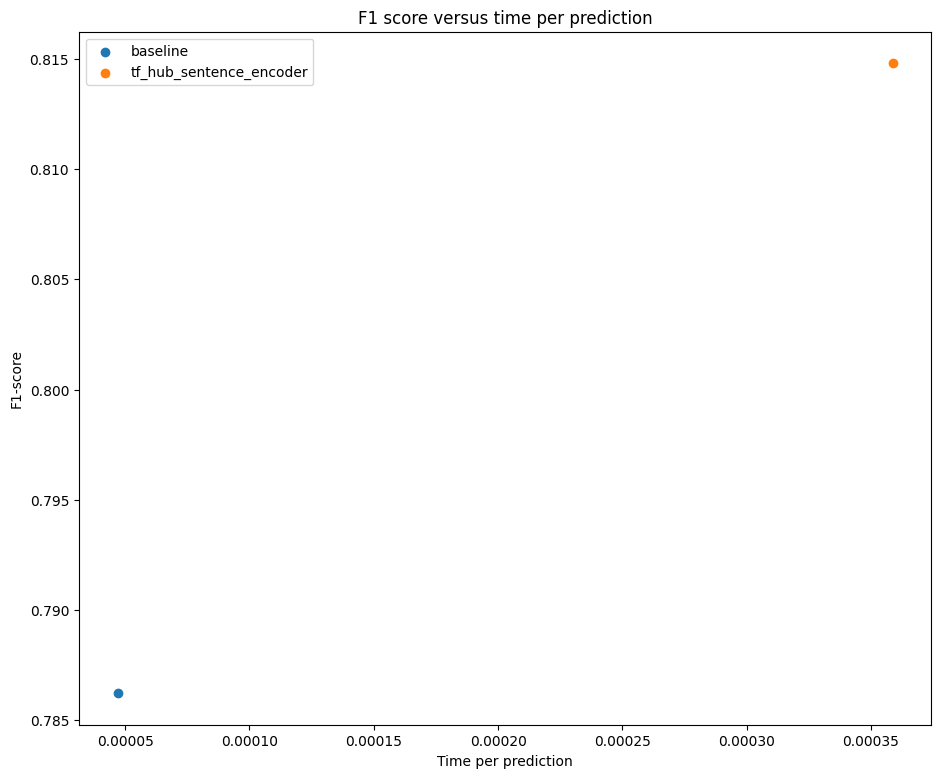

In [170]:
import matplotlib.pyplot as plt

plt.figure(figsize=(11, 9))
plt.scatter(baseline_time_per_pred, baseline_results["f1"], label='baseline')
plt.scatter(model_6_time_per_pred, model_6_pretrained_results['f1'], label='tf_hub_sentence_encoder')
plt.legend()
plt.title("F1 score versus time per prediction")
plt.xlabel("Time per prediction")
plt.ylabel("F1-score")